# Are Graphs Unique?
This notebook shows how to determine if each entry in the HydroNet dataset represents a unique graph. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.data import graph_from_dict
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
import networkx as nx
import pandas as pd
import numpy as np

Configuration

In [2]:
cluster_size = 18

## Load in the Data
Load in a small dataset from disk

In [3]:
%%time
data = pd.read_json('../data/output/atomic_valid.json.gz', lines=True)
print(f'Loaded {len(data)} records')

Loaded 224018 records
CPU times: user 33.1 s, sys: 5.7 s, total: 38.8 s
Wall time: 38.8 s


## Find Pairs of Isomorphic Graphs
Assess how many training records are isomorphic

In [4]:
data.query(f'n_waters=={cluster_size}', inplace=True)
print(f'Downselected to {len(data)} graphs')

Downselected to 5714 graphs


Generate networkx objects for each

In [5]:
%%time
data['nx'] = data.apply(graph_from_dict, axis=1)

CPU times: user 1.66 s, sys: 170 ms, total: 1.83 s
Wall time: 1.83 s


Compute which graphs are isomorphic

In [6]:
data.reset_index(inplace=True)

In [7]:
matches = [[] for _ in range(len(data))]
n_matches = 0
with Pool() as p:
    for i, g in tqdm(enumerate(data['nx']), total=len(data)):
        f = partial(nx.algorithms.is_isomorphic, g, node_match=dict.__eq__, edge_match=dict.__eq__)
        is_match = p.map(f, data['nx'].iloc[i+1:])
        for j, hit in enumerate(is_match):
            if hit:
                n_matches += 1
                j_real = i + j + 1
                matches[i].append(j_real)
                matches[j_real].append(i)
print(f'Found {n_matches} pairs of isomorphic graphs')

100%|██████████| 5714/5714 [26:46<00:00,  3.56it/s] 


Found 5 pairs of isomorphic graphs


Add to the dataframe for safe keeping

In [8]:
data['matches'] = matches

In [9]:
data['n_matches'] = data['matches'].apply(len)

## Assess Energy Differences between Isomorphic Graphs
We want to know how large they are. Does each graph represent a local minimum, or they actually very different in energy?

In [10]:
energy_diffs = []
for rid, row in data.query('n_matches>0').iterrows():
    for m in row['matches']:
        if m > rid:
            energy_diffs.append(abs(row['energy'] - data.iloc[m]['energy']))

In [11]:
print(f'Maximum: {np.max(energy_diffs):.2e} kcal/mol')
print(f'Median:  {np.percentile(energy_diffs, 50):.2e} kcal/mol')
print(f'Minimum: {np.min(energy_diffs):.2e} kcal/mol')

Maximum: 1.50e-01 kcal/mol
Median:  5.48e-02 kcal/mol
Minimum: 1.04e-02 kcal/mol


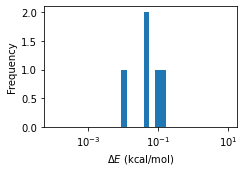

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bins = np.logspace(-4, 1, 32)
ax.hist(energy_diffs, bins=bins)
ax.set_xscale('log')

ax.set_xlabel('$\Delta E$ (kcal/mol)')
ax.set_ylabel('Frequency')
fig.tight_layout()
fig.savefig(f'figures/energy-difference-isomorphic-graphs-size-{cluster_size}.png', dpi=320)

For comparision, print out the range of energies for clusters

In [13]:
(data['energy'] - data['energy'].min()).describe()

count    5714.000000
mean        9.796442
std         3.858295
min         0.000000
25%         6.805695
50%         9.751564
75%        12.744919
max        24.997681
Name: energy, dtype: float64